In [1]:
# author: Carlos F. Dietrich (carlos.dietrich@tum.de)
# reviewer: Francisco J. Guerrero-Gonzalez
# version: 1.0.0

Copyright 2023, Professorship of Lunar and Planetary Exploration, Technical University of Munich.

Permission is hereby granted, free of charge, to any person obtaining a copy of this model and associated documentation files, without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the models, and to permit persons to whom the model is furnished to do so, subject to the following conditions:

1. The above copyright notice and this permission notice shall be included in all copies or substantial portions of the model, as well as reference to the author(s) listed above. Scientific publications which use this model shall cite the [ISRULib documentation site](https://wiki.tum.de/display/lpe/ISRULib) attributing credit to the named authors in the documentation.

2. The model is provided without warranty of any kind, express or implied, including but not limited to the warranties of merchantability, fitness for a particular purpose, and non-infringement. In no event shall the authors or copyright holders be liable for any claim, damages, or other liability, whether in an action of contract, tort, or otherwise, arising from, out of, or in connection with the model or the use or other dealings in the model.

# Auger Conveyor (Screw Conveyor)

In [2]:
# Python Libraries
import numpy as np
import matplotlib.pyplot as plt

from IPython import display

**Model Description**

Auger conveyor model moves granular material (e.g., regolith) by rotation of a screw in a housing. The material is pushed through the casing and transported from one side of the conveyor to the otherone. The material movement can be horizontal (horizontal auger conveyor) or vertical (inclined auger conveyor up to 45°).

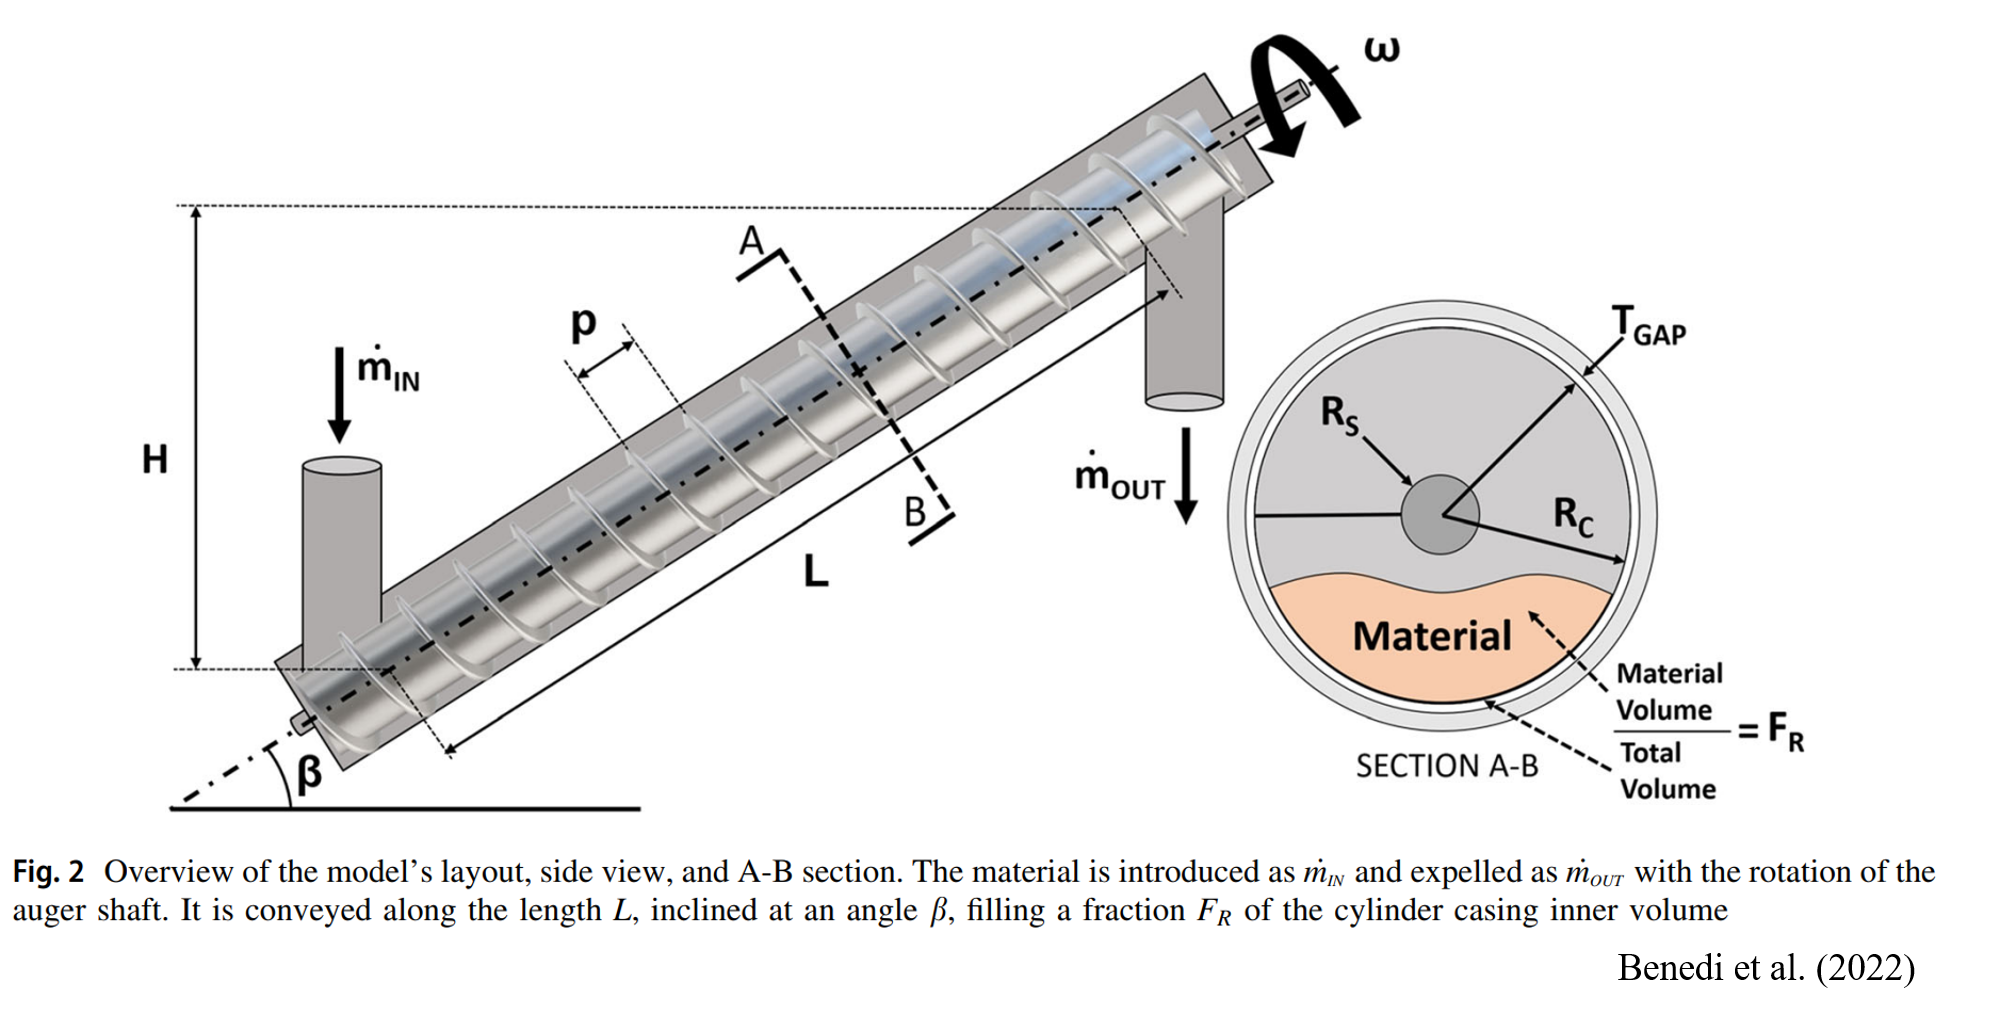

In [3]:
# Include here a descriptive figure of the component (model)
display.Image("./figs/auger_conveyor.png")

**Model Assumptions, Simplifications and future Improvements**

The model aims to compute the aproximate mass and power of an auger conveyor system for regolith. It is assumed that the auger conveyor consists of a tube-housing, a shaft, and the screw which is fixed on the shaft. The overall volume of the screw is computed assumming that a screw rotation is equivalent to a disc. The model does not include the mass of the rotating actuator (motor). Moreover, the mass of the supporting structure (e.g., bearings is neglected). The mass of additional length of the housing, which might be needed, is also not considered.

The model does not consider the effects of temperature, vacuum, or the electrostatic charge and adhesion of the regolith particles. 

The geometries and the boundary conditions (e.g. rotational speed) of the systems are assumptions and can be adapted in **1. Inputs**.

The mass flow is computed based on the Benedi model (Benedi et al., 2022). The bulk density of the conveyed regolith material is assumed to be the same when augered as on the surface of the Moon. 

The power is adapted from Bendi et al. (2022), which is based on the ANSI/CEMA Standard 350. The formulas by Benedi et al. seem to not match with the units proposed by the authors. Hence, the formulas in the model are based on the ANSI/CEMA Standart 350. The factors used in the power calculation are assumed to be constant. The motor efficency is assumed to be 50%.

Future improvements could include:
- Optimized mass estimation of screw
- Include additional structural mass and motor depending on application
- Include adaptive factor selection for power calculation (e.g., factor Fd depending on diameter)

The rest of the assumptions and possible improvements are explained thoroughly in **1. Inputs** and **3. Model Body**.

## 1. Inputs

In [42]:
# Auger conveyor geometry
Length = 5 # m | Length Between Inlet and Outlet, i.e., how far material is transported if the conveyor is completely horizontal
Beta = 0 # degrees | inclination angle. A value between 0 and 45 degrees must be entered for the model to hold

inner_radius = 0.076 # m | inner Radius of the auger casing (Benedi et al., 2022)
shaft_radius = 0.039 # m | shaft radius (Benedi et al., 2022)

t_Tube  = 0.002 # m | Thickness of auger casing. Rough estimation
t_Gap   = 0.001 # m | Gap between case and the screw (Radulescu et al., 2011)
t_Blade = 0.002 # m | Thickness of blade of Screw (considered equal to t_Tube)
pitch   = 0.078 # m | Distance between two "Screw-blades", i.e., the pitch is the distance between each complete rotation of the helix (Benedi et al., 2022)

ejection_nozzle_width = 0.064 # m | Ejection nozzle width (Benedi et al., 2022)

filling_ratio = 0.15 # - | Filling ratio (FR) -> material volume divided by the total volume (Benedi et al., 2022)

rotational_speed = 425 # rpm | Rotational speed of the augr screw. Assumption based on Benedi et al. (2022)

# Factors needed to estimate the auger conveyor power (Benedi et al., 2022)
# These factors increase the power consumption predictions if:
# higher friction bearings, materials more difficult to transport, wider diameter augers or different flight shapes are used
Fd = 4 # - | Factor depening on diameter, adopt depending on diameter # 4 is selected as it is for small diameters (Benedi et al., 2022)
Fb = 1 # - | Factor for Bearings (Benedi et al., 2022)
Ff = 1 # - | Factor for Flights (Benedi et al., 2022)
Fm = 2 # - | Factor for Material (Benedi et al., 2022)
Fp = 1 # - | Factor for intermediate paddles (Benedi et al., 2022)

# Motor Efficency
MotorEfficency = 0.5 # - | Adapted from (Linne et al., 2021)

# Tabular data to adapt the inclination angle (Beta) to a unitless inclination coefficient (C) for calculations (Benedi et al., 2022)
Table1=[
    ['Beta','C'],
    
    [0,1],
    [5,0.97],
    [10,0.9],
    [15,0.7],
    [20,0.55],
    [25,0.42],
    [30,0.3],
    [35,0.23],
    [40,0.17],
    [45,0.1]
    ] 

## 2. Constants

In [43]:
pi = np.pi # -

g = 1.625 # m/s2 | Gravitational acceleration on the Moon

density_regolith = 1500 # kg/m3 | Fixed bulk regolith density (Schreiner et al., 2016)
density_Al       = 2700 # kg/m3 | Assuming a aluminum as auger conveyor material

## 3. Model Body

In [44]:
# Basic geometric calculations
outer_radius = inner_radius + t_Tube  # m | Outer radius of the auger casing
outer_radius_screw = outer_radius - t_Tube - t_Gap # m | Outer radius of the screw
height = Length*np.sin(Beta*pi/180) # m | height that the auger conveyor reaches 

Beta_rounded = 5*np.round(Beta/5) # deg | rounded inclination angle to match inclination coefficent values
# Beta is first rounded up (to be conservative), then beta is matched to the matching value from Table 1
for i in range(0, 10, 1):
    if Beta_rounded == Table1[i][0]:
        C = Table1[i][1]
        break

# Volume of auger conveyor parts
Volume_Tube  = pi*((outer_radius**2)-(outer_radius-t_Tube)**2)*Length # m3 | Volume of the casing
Volume_Shaft = pi*shaft_radius**2*Length # m3 | Volume of the shaft
Volume_Screw = (Length/pitch)*pi*(outer_radius_screw**2-shaft_radius**2)*t_Blade # m3 | Volume of the screw blades

# Mass of auger conveyor parts
Mass_Tube  = density_Al*Volume_Tube # kg | Mass of the casing
Mass_Shaft = density_Al*Volume_Shaft # kg | Mass of the shaft
Mass_Screw = density_Al*Volume_Screw # kg | Mass of the screw blades
Mass_Total = Mass_Tube + Mass_Shaft + Mass_Screw # kg | Total mass of the auger conveyor

# Throughput (mass flow) of the auger conveyor
m_dot_out = filling_ratio*C*0.5*rotational_speed*density_regolith*ejection_nozzle_width*(outer_radius_screw**2-shaft_radius**2) # kg/s | Output mass flow (Benedi et al., 2022)

# Power consumption of the auger conveyor
# The power consumption to operate the auger is split into 3 different terms:
# - Pst: Power to overcome height
# - Pf: Power to overcome friction 
# - Pm: Power to move material
# Some factors are included in the following formulas to change from SI units to imperial units and viceversa: 
# 3.28: meter in ft
# 3600: sec in hour
# 2.205: kg in lb
Pst = m_dot_out*g*height # W | Power to overcome height, adapted from Benedi et al. (2022) and  ANSI/CEMA Standard 350 (2019)
Pf  = Length*3.28*rotational_speed*Fd*Fb/1e6 # hp (horse power) | Power to overcome friction (ANSI/CEMA Standard 350, 2019)
Pm  = m_dot_out*3600*2.205*Length*3.28*Ff*Fm*Fp/(1e6) # hp (horse power) | Power to transport material (ANSI/CEMA Standard 350, 2019)

Poverload = Pf + Pm # hp (horse power) | sum of Pf and Pm to apply factor in next step (ANSI/CEMA Standard 350, 2019)
# For Pf and Pm an overload factor is applied for small powers
if Poverload <= 0.2: # (ANSI/CEMA Standard 350, 2019)
    Fo = 3 # - | Overload factor
elif Poverload > 0.2 and Poverload < 5.2:
    Fo = 77/25 -2*Poverload/5 # - | Overload factor
else:
    Poverload = 1 # - | Overload factor

P_Fo = Poverload*Fo # hp (horse power) | Overload factor for small powers (ANSI/CEMA Standard 350, 2019). 

P_Fo_W=P_Fo*745.7 # W | Convert hp (horse power) into W 

P = P_Fo_W + Pst # W | Total power is sum of all 3 power components (Benedi et al., 2022) 
Power = P/MotorEfficency # W | Power including motor efficiency

Mass_per_Length = Mass_Total/Length # kg/m | Mass per length 
Mass_per_Output = Mass_Total/m_dot_out # (kg/s) | System mass per mass flow

## 4. Outputs

In [46]:
print("Mass:  %.2f kg"%(Mass_Total))
print("Power: %.2f W"%(Power))
print()
print("Output:                      %.2f kg/s"%(m_dot_out))
print("Mass per unit of length:     %.2f kg/m"%(Mass_per_Length))
print("Mass per unit of mass flow:  %.2f kg/(kg/s)"%(Mass_per_Output))

Mass:  166.50 kg
Power: 8660.49 W

Output:                      12.56 kg/s
Mass per unit of length:     33.30 kg/m
Mass per unit of mass flow:  13.26 kg/(kg/s)


## References

ANSI/CEMA Standard 350: Screw Conveyors for Bulk Materials, 2019, URL https://cemanet.org/wp-content/uploads/2019/06/ANSI-CEMA-350-FinalReview.pdf

J. Benedi, G. H. Just, M. J. Roy, K. L. Smith, A novel approach to the analytical modelling of an auger conveyor system for lunar regolith transportation, Acta Geotechnica 17 (2022), 5841-5855, https://doi.org/10.1007/s11440-022-01527-3

D.L. Linne, J.M. Schuler, L. Sibille, J.E. Kleinhenz, A.J. Colozza, H.J. Fincannon, S.R. Oleson, N.H. Suzuki, L. Moore, Lunar Production System for Extracting Oxygen from Regolith, Journal of Aerospace Engineering 34 (4) (2021) 04021043-1-13, https://doi.org/10.1061/(ASCE)AS.1943-5525.0001269

M.-V. Radelescu, B. Landon, K. Moditis, T. Friedlaender, P. H. Radziszewski, Excavation System for Lunar Resource Management Based on Screw Conveying Auger Technology, in: 49th AIAA Aerospace Sciences Meeting Including the New Horizons Forum and Aerospace Exposition, American Institute of Aeronautics and Astronautics, Orlando, Florida, 2011, https://doi.org/10.2514/6.2011-125

S.S. Schreiner, J.A. Dominguez, L. Sibille, J.A. Hoffman, Thermophysical property models for lunar regolith, Adv. Space Res. 57 (5) (2016) 1209–1222, http://dx.doi.org/10.1016/j.asr.2015.12.035